In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from tensorflow import keras
# plt.rcParams['font.sans-serif']=['SimHei']
# plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
print(tf.__version__)
print(sys.version_info)
import h2o
from h2o.automl import H2OAutoML
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.12.0
sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)
matplotlib 3.7.1
numpy 1.23.5
pandas 2.0.1
sklearn 1.2.2
tensorflow 2.12.0
keras.api._v2.keras 2.12.0


In [2]:
if os.environ.get('COMPUTERNAME') == 'DESKTOP-EQAO3M5' or os.environ.get('NAME') == 'DESKTOP-EQAO3M5':
  if os.environ.get('WSL_DISTRO_NAME') == 'Ubuntu-20.04':
    computer_flag = 'home_WSL2'
  else:
    computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  root_dir = "F:/github/pythonScript/seafog/"
elif computer_flag == 'home_WSL2':
  root_dir = "/mnt/f/github/pythonScript/seafog/"
else:
  root_dir = "H:/github/python/seafog/"

def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

def reverse_linear_vis(x):
    if(x<0):
      y = 1
    elif(x <= 1.0):
      y = x*1000.0
    elif(x <= 2.0):
      y = (x - 1.0)*9000.0 + 1000.0
    elif(x <= 3.0):
      y = (x-2.0)*20000 + 10000.0
    else:
      y = 30000.0
    return y

def setDataset(df, x_columns):
    df['t_td'] =  df['t2mm'] - df['t2md']
    df['td_sst'] =  df['t2md'] - df['sstk']
    df['t_sst'] =  df['t2mm'] - df['sstk']
    df['delta_theta'] = df['theta925'] - df['theta1000']
    df['delta_theta_e'] = df['theta_e925'] - df['theta_e1000']
    df_x = df.loc[:, x_columns]
    df_y = df['station_vis_linear']
    _x = df_x.to_numpy()
    _y = df_y.to_numpy()
    return (_x, _y)


def getLevelRatio(df):
    length = len(df)
    ratio_fog = len(df.loc[df['prediction']<=1.0])/length
    ratio_mist = len(df.loc[(df['prediction']>1.0) & (df['prediction']<=2.0)])/length
    ratio_clear = len(df.loc[df['prediction']>2.0])/length
    print(f'比例: 雾:{ratio_fog}, 轻雾{ratio_mist}, 无雾{ratio_clear}')
    return (ratio_fog, ratio_mist, ratio_clear)

def get_fog_TSscore(df, threshold=1.0):
    length = len(df)
    NA = len(df.loc[(df['prediction']<=threshold) & (df['y']<=threshold)]) # 正确数
    NB = len(df.loc[(df['prediction']<=threshold) & (df['y']>threshold)]) # 空报数
    NC = len(df.loc[(df['prediction']>threshold) & (df['y']<=threshold)]) # 空报数
    TS_score = NA/(NA + NB + NC)
    return TS_score

def get_NWP_score(df):
    y = df['station_vis'].apply(linear_vis)
    y_p = df['visi'].apply(linear_vis)
    df_s = pd.DataFrame({'prediction':y_p, 'y':y})
    df_s.dropna(inplace=True)
    df_s_fog = df_s.loc[df_s['y']<=1.0]
    df_s_mist = df_s.loc[(df_s['y']>1.0) & (df_s['y']<=2.0)]
    df_s_clear = df_s.loc[df_s['y']>2.0]
    print('* 实况为雾时:', end=' ')
    getLevelRatio(df_s_fog)
    # print('-------------')
    print('* 实况为轻雾时:', end=' ')
    # print('-------------')
    getLevelRatio(df_s_mist)
    print('* 实况为无雾时:', end=' ')
    getLevelRatio(df_s_clear)
    print('* TS评分:', end=' ')
    TS_fog = get_fog_TSscore(df_s, threshold=1.0)
    TS_fog_mist = get_fog_TSscore(df_s, threshold=2.0)
    print(f'雾: {TS_fog}, 轻雾及雾: {TS_fog_mist}')

def getScore(x,y, model):
    predictions = model.predict(x)
    y_p = predictions.as_data_frame().values.flatten()
    df_s = pd.DataFrame({'prediction':y_p, 'y':y})
    df_s_fog = df_s.loc[df_s['y']<=1.0]
    df_s_mist = df_s.loc[(df_s['y']>1.0) & (df_s['y']<=2.0)]
    df_s_clear = df_s.loc[df_s['y']>2.0]
    print('* 实况为雾时:', end=' ')
    getLevelRatio(df_s_fog)
    # print('-------------')
    print('* 实况为轻雾时:', end=' ')
    # print('-------------')
    getLevelRatio(df_s_mist)
    print('* 实况为无雾时:', end=' ')
    getLevelRatio(df_s_clear)
    print('* TS评分:', end=' ')
    TS_fog = get_fog_TSscore(df_s, threshold=1.0)
    TS_fog_mist = get_fog_TSscore(df_s, threshold=2.0)
    print(f'雾: {TS_fog}, 轻雾及雾: {TS_fog_mist}')
    return {'TS_fog':TS_fog,'TS_mist':TS_fog_mist}

In [3]:
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fullhour/fog_dataset_fulltime.hdf"
# fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './fullhour/fog_dataset_72h1_168h6.hdf'))
# fog_dataset_hdf = os.path.normpath(os.path.join(root_dir, './data/collection/fog_dataset_allstation.h5'))
# fog_dataset_hdf = os.path.normpath(os.path.join(root_dir, './data/collection/fog_dataset_hdf66_fc120h.h5'))
fog_dataset_hdf = os.path.normpath(os.path.join(root_dir, './data/collection/fog_dataset_hdf66_fc120h_v2.h5'))
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')
df_valid_test = store_dataset.get('valid_test')

real_fcHour_list = list(range(0, 72+1, 3)) + list(range(78, 168+1, 6))
df_test_real = df_test.loc[df_test['fc_hour'].isin(real_fcHour_list) ].copy(deep=True)
df_valid_test_real = df_valid_test.loc[df_valid_test['fc_hour'].isin(real_fcHour_list) ].copy(deep=True)

x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e','theta_e925']

(train_x, train_y) = setDataset(df_train, x_columns)
(valid_x, valid_y) = setDataset(df_valid, x_columns)
(test_x,  test_y)  = setDataset(df_test, x_columns)
(valid_test_x, valid_test_y) = setDataset(df_valid_test, x_columns)

(test_real_x,  test_real_y)  = setDataset(df_test_real, x_columns)
(valid_test_real_x, valid_test_real_y) = setDataset(df_valid_test_real, x_columns)



print(train_x.shape)
print(train_y.shape)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled  = scaler.transform(test_x)
valid_x_scaled = scaler.transform(valid_x)
valid_test_x_scaled = scaler.transform(valid_test_x)

test_x_real_scaled  = scaler.transform(test_real_x)
valid_test_x_real_scaled = scaler.transform(valid_test_real_x)


keep_cols = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e'] # 不需要标准化变量的参数

for iColumn in keep_cols:
    index = x_columns.index(iColumn)
    train_x_scaled[:,index] = train_x[:,index]
    valid_x_scaled[:,index] = valid_x[:,index]
    test_x_scaled[:,index]  = test_x[:,index]
    valid_test_x_scaled[:,index]  = valid_test_x[:,index]

    test_x_real_scaled[:,index]  = test_real_x[:,index]
    valid_test_x_real_scaled[:,index]  = valid_test_real_x[:,index]


['/test', '/train', '/valid', '/valid_test']
(469269, 17)
(469269,)


In [4]:
# 初始化H2O集群
h2o.init()

# 将数据转换为H2O数据框
train = h2o.H2OFrame(train_x_scaled, column_names=x_columns)
train['target'] = h2o.H2OFrame(train_y)
valid = h2o.H2OFrame(valid_x_scaled, column_names=x_columns)
valid['target'] = h2o.H2OFrame(valid_y)
x = train.columns
y = "target"
x.remove(y)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,11 hours 49 mins
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_minhill_hzrs2p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.359 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
h2o.export_file(train, path=os.path.join(root_dir, './src/h2o/train_h2o.csv'), force=True)
h2o.export_file(valid, path=os.path.join(root_dir, './src/h2o/valid_h2o.csv'), force=True)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


In [7]:
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

# Define the hyperparameters grid
hyper_params = {'hidden': [[50,50], [100,100], [50,50,50], [100,100,100]],
                'l1': [0, 0.0001, 0.001, 0.01],
                'l2': [0, 0.0001, 0.001, 0.01],
                'input_dropout_ratio': [0, 0.05, 0.1, 0.15, 0.2]}

# Define the search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 50, 'seed': 1, 
                   'stopping_rounds': 5, 'stopping_metric': 'RMSE', 'stopping_tolerance': 0.01}

# Initialize the grid search

# Initialize the grid search
grid = H2OGridSearch(model=H2ODeepLearningEstimator,
                     hyper_params=hyper_params,
                     search_criteria=search_criteria,
                     grid_id='dl_grid')

# Train the grid
grid.train(x=x, y=y, training_frame=train, validation_frame=valid)


deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%


,hidden,input_dropout_ratio,l1,l2,model_ids,residual_deviance
,"[50, 50]",0.2,0.001,0.01,dl_grid_model_62,0.2098893
,"[50, 50]",0.2,0.0001,0.001,dl_grid_model_2,0.2145846
,"[50, 50, 50]",0.1,0.0,0.0001,dl_grid_model_13,0.2156353
,"[50, 50]",0.05,0.01,0.0001,dl_grid_model_60,0.2178148
,"[100, 100]",0.15,0.0001,0.001,dl_grid_model_50,0.2212004
,"[50, 50, 50]",0.15,0.0,0.0001,dl_grid_model_54,0.2216958
,"[50, 50]",0.05,0.001,0.0001,dl_grid_model_59,0.2225752
,"[50, 50, 50]",0.1,0.01,0.001,dl_grid_model_47,0.2229119
,"[50, 50, 50]",0.2,0.0,0.0001,dl_grid_model_15,0.2232968
,"[100, 100, 100]",0.1,0.01,0.0001,dl_grid_model_5,0.2278125


In [8]:
# Get the grid results
grid_results = grid.get_grid(sort_by='RMSE', decreasing=False)

# Print the grid results
print(grid_results)

Hyper-Parameter Search Summary: ordered by increasing RMSE
     hidden           input_dropout_ratio    l1      l2      model_ids         rmse
---  ---------------  ---------------------  ------  ------  ----------------  -------------------
     [50, 50]         0.2                    0.001   0.01    dl_grid_model_62  0.4581367841842313
     [50, 50]         0.2                    0.0001  0.001   dl_grid_model_2   0.4632327410120177
     [50, 50, 50]     0.1                    0.0     0.0001  dl_grid_model_13  0.46436552990674684
     [50, 50]         0.05                   0.01    0.0001  dl_grid_model_60  0.4667063110811841
     [100, 100]       0.15                   0.0001  0.001   dl_grid_model_50  0.4703194558185528
     [50, 50, 50]     0.15                   0.0     0.0001  dl_grid_model_54  0.47084578447786224
     [50, 50]         0.05                   0.001   0.0001  dl_grid_model_59  0.47177876311786515
     [50, 50, 50]     0.1                    0.01    0.001   dl_grid_

In [11]:
# 遍历并保存每个模型
model_score_list = []
for i_model in grid_results.models:
    model_id = i_model.model_id
    print(f'#### =========={model_id}=========测试集==========')
    i_score = getScore(h2o.H2OFrame(test_x_scaled, column_names=x_columns), test_y, i_model)
    i_score['model_id'] = model_id
    model_score_list.append(i_score)

#### ==========dl_grid_model_62=========测试集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.7012283802832658, 轻雾0.29208153402098763, 无雾0.006690085695746538
* 实况为轻雾时: 比例: 雾:0.38679435258317857, 轻雾0.6123330275434632, 无雾0.0008726198733582441
* 实况为无雾时: 比例: 雾:0.013603920076969547, 轻雾0.24509431007092833, 无雾0.7413017698521022
* TS评分: 雾: 0.500734965169042, 轻雾及雾: 0.8821175258548956
#### ==========dl_grid_model_2=========测试集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.6703734365560602, 轻雾0.3243237195981474, 无雾0.005302843845792406
* 实况为轻雾时: 比例: 雾:0.33090193095115567, 轻雾0.6625646074329313, 无雾0.006533461615913006
* 实况为无雾时: 比例: 雾:0.0098896918980601, 轻雾0.2855704472

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

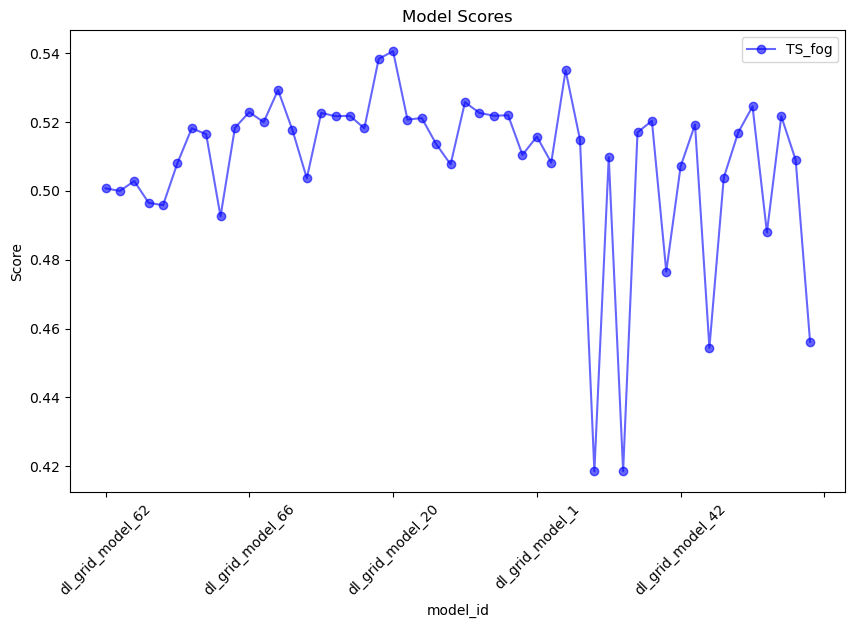

In [16]:
df = pd.DataFrame(model_score_list)

# Set the model ID as the index
df.set_index('model_id', inplace=True)

# Plot the scores
plt.figure(figsize=(10, 6))
df['TS_fog'].plot(kind='line', marker='o', color='blue', alpha=0.6, label='TS_fog')
# df['TS_mist'].plot(kind='line', marker='o', color='red', alpha=0.6, label='TS_mist')
plt.ylabel('Score')
plt.title('Model Scores')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [17]:
# Find the model_id with the maximum TS_fog score
best_model_id = df['TS_fog'].idxmax()

print("The model_id with the maximum TS_fog score is:", best_model_id)

The model_id with the maximum TS_fog score is: dl_grid_model_20


In [19]:
df['TS_fog'].max()

0.5405736700171611

In [18]:
# Get the best model
best_model = h2o.get_model(best_model_id)

# Save the model
model_path = h2o.save_model(model=best_model, path="/mnt/f/github/pythonScript/seafog/src/h2o/h2o_model_v4_best", force=True)

print("The model is saved to:", model_path)

The model is saved to: /mnt/f/github/pythonScript/seafog/src/h2o/h2o_model_v4_best/dl_grid_model_20


In [20]:
print('#### ==================训练集==========')
getScore(h2o.H2OFrame(train_x_scaled, column_names=x_columns), train_y, best_model)
print('#### ===============验证集==========')
getScore(h2o.H2OFrame(valid_x_scaled, column_names=x_columns), valid_y, best_model)
print('#### ===================测试集-预报==========')
getScore(h2o.H2OFrame(test_x_scaled, column_names=x_columns), test_y, best_model)
print('#### ===================测试集+验证==========')
getScore(h2o.H2OFrame(valid_test_x_scaled, column_names=x_columns), valid_test_y, best_model)

#### ==================训练集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.9121804338236704, 轻雾0.08774924403700222, 无雾7.032213932733677e-05
* 实况为轻雾时: 比例: 雾:0.1325508397102728, 轻雾0.737314845003612, 无雾0.13013431528611522
* 实况为无雾时: 比例: 雾:0.010267032341791169, 轻雾0.34345972139646985, 无雾0.646273246261739
* TS评分: 雾: 0.7981853068028619, 轻雾及雾: 0.7943978032305115
#### ===============验证集==========
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
* 实况为雾时: 比例: 雾:0.7821310301619977, 轻雾0.21786896983800233, 无雾0.0
* 实况为轻雾时: 比例: 雾:0.27085384408842744, 轻雾0.726103105701244, 无雾0.0030430502103284706
* 实况为无雾时: 比例: 雾:0.006667860019690325, 轻雾0.3186923834243265, 无雾0.6746397565559832
* TS评分: 雾: 0.61222523863

{'TS_fog': 0.5763960035376222, 'TS_mist': 0.8587482253290661}

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

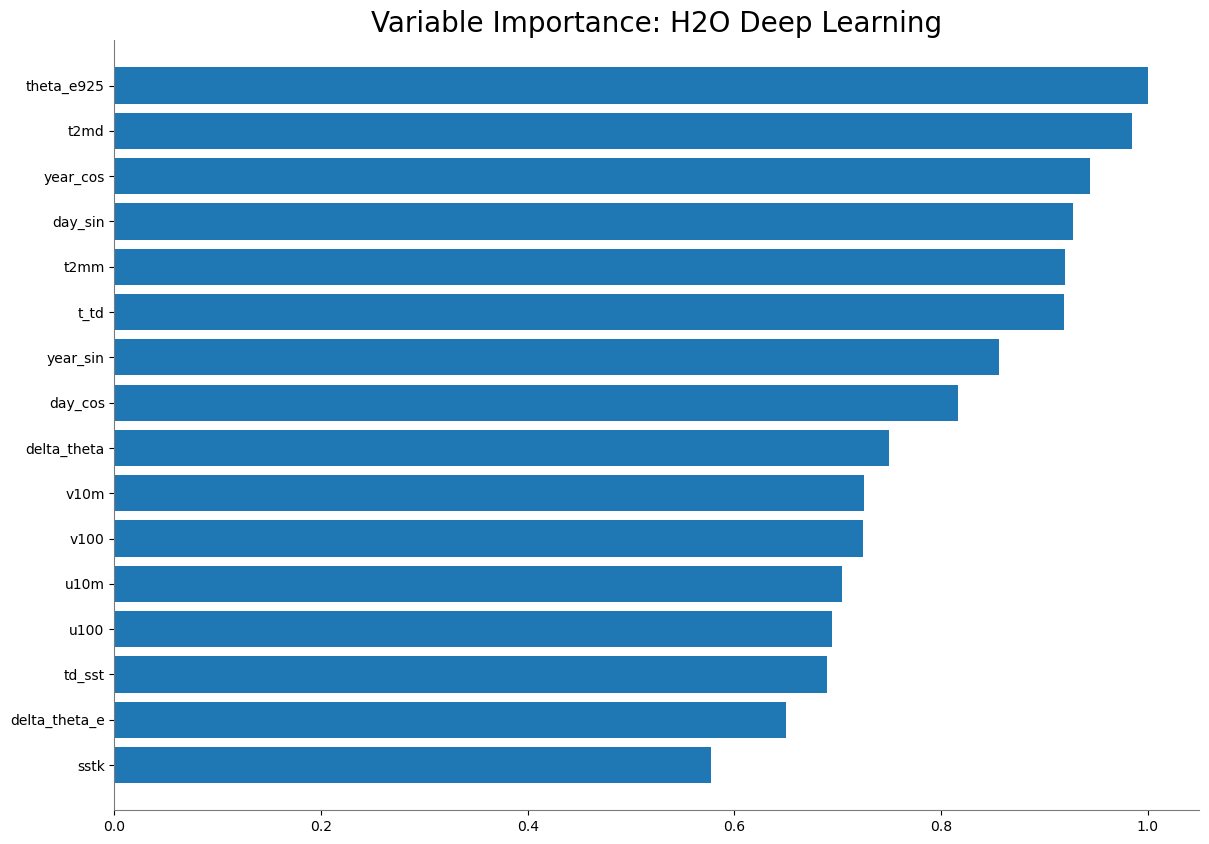

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: dl_grid_model_20


Status of Neuron Layers: predicting target, regression, gaussian distribution, Quadratic loss, 12,001 weights/biases, 149.0 KB, 4,697,894 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2     mean_rate             rate_rms               momentum    mean_weight            weight_rms           mean_bias            bias_rms
--  -------  -------  ---------  ---------  ----  -----  --------------------  ---------------------  ----------  ---------------------  -------------------  -------------------  -----------------------
    1        17       Input      10.0
    2        100      Rectifier  0.0        0.0   0.001  0.005083441106527222  0.002701212652027607   0.0         -0.012406822691906093  0.11971616744995117  0.14409432933874824  0.09640023112297058
    3        100      Rectifier  0.0        0.0   0.001  0.09217286734286463   0.12103700637817383    0.0         -0.034628525418416815  0.09453150629997253  0.461778177881325    0.24354463815689087
    4        1        Linear                0.0   0.001  0.002009906462626532  0.0014314129948616028  0.0         -0.023738203288594377  0.1126563549041748   0.10883596755821583  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.15665213475664222
RMSE: 0.3957930453616413
MAE: 0.30100969782127807
RMSLE: 0.17418377335025145
Mean Residual Deviance: 0.15665213475664222

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.2393059255815646
RMSE: 0.48918904891827314
MAE: 0.3830564655851142
RMSLE: 0.2627246617724592
Mean Residual Deviance: 0.2393059255815646

Scoring History: 
    timestamp            duration          training_speed    epochs    iterations    samples      training_rmse    training_deviance    training_mae    training_r2    validation_rmse    validation_deviance    validation_mae    validation_r2
--  -------------------  ----------------  ----------------  --------  ------------  -----------  ---------------  -------------------  --------------  -------------  -----------------  ---------------------  ----------------  ---------------
    2023-05-18 09:47:14  0.000 sec                           0         0             0            nan              nan                  nan             nan            nan                nan                    nan               nan
    2023-05-18 09:47:15  5 min 19.903 sec  124878 obs/sec    0.212891  1             99903        0.395793         0.156652             0.30101         0.781572       0.489189           0.239306               0.383056          0.720433
    2023-05-18 09:47:20  5 min 24.903 sec  213829 obs/sec    2.55491   12            1.19894e+06  0.338555         0.114619             0.253388        0.84018        0.511829           0.261969               0.393479          0.693957
    2023-05-18 09:47:25  5 min 30.134 sec  234686 obs/sec    5.32218   25            2.49754e+06  0.335922         0.112843             0.258196        0.842657       0.589156           0.347105               0.452655          0.594498
    2023-05-18 09:47:30  5 min 35.372 sec  242158 obs/sec    8.09244   38            3.79753e+06  0.323012         0.104337             0.244624        0.854518       0.526467           0.277167               0.408608          0.676202
    2023-05-18 09:47:34  5 min 39.020 sec  245885 obs/sec    10.0111   47            4.69789e+06  0.323656         0.104753             0.241503        0.853937       0.527413           0.278165               0.407474          0.675036
    2023-05-18 09:47:34  5 min 39.220 sec  245872 obs/sec    10.0111   47            4.69789e+06  0.395793         0.156652             0.30101         0.781572       0.489189           0.239306               0.383056          0.720433

Variable Importances: 
variable       relative_importance    scaled_importance    percentage
-------------  ------

,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
,1,17,Input,10.0,,,,,,,,,
,2,100,Rectifier,0.0,0.0,0.001,0.0050834,0.0027012,0.0,-0.0124068,0.1197162,0.1440943,0.0964002
,3,100,Rectifier,0.0,0.0,0.001,0.0921729,0.1210370,0.0,-0.0346285,0.0945315,0.4617782,0.2435446
,4,1,Linear,,0.0,0.001,0.0020099,0.0014314,0.0,-0.0237382,0.1126564,0.1088360,0.0000000


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

<Figure size 640x480 with 0 Axes>

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

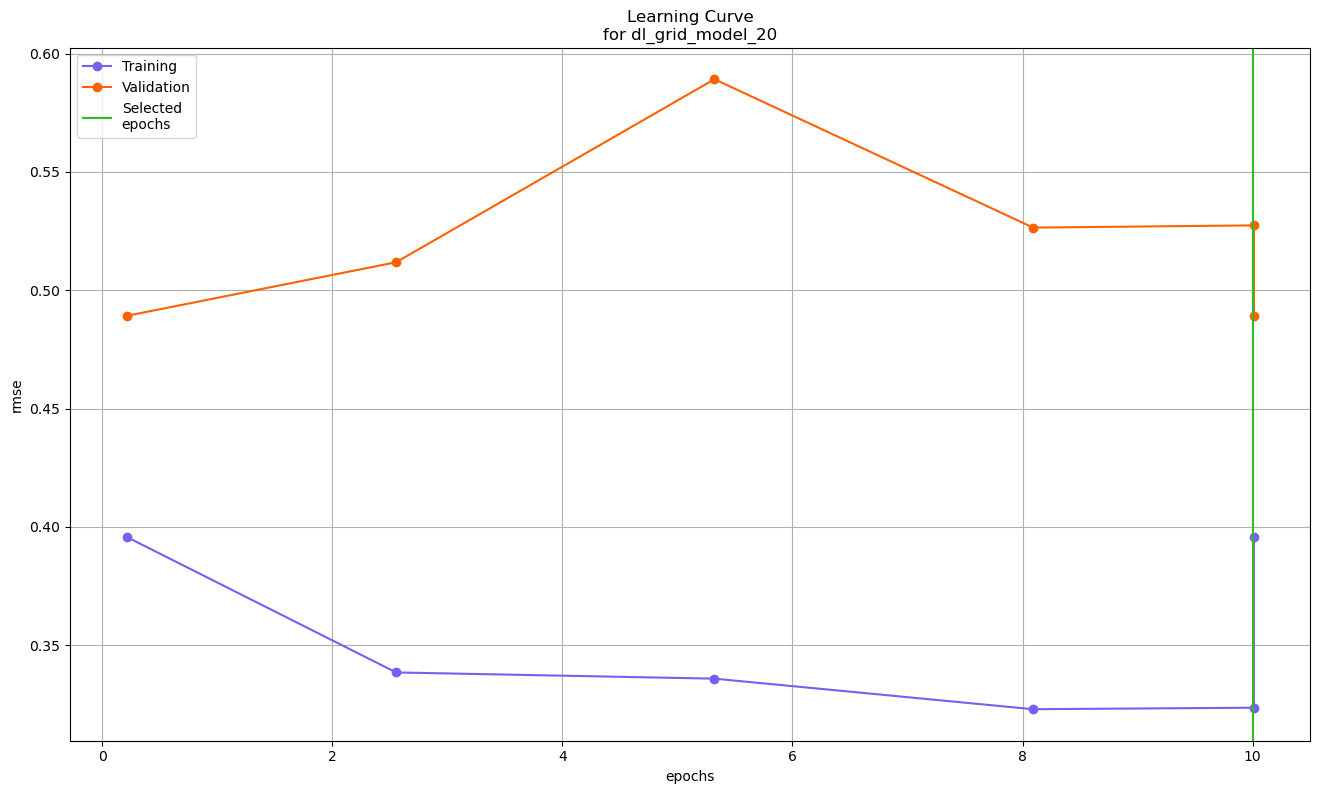

In [21]:

ra_plot = best_model.varimp_plot(num_of_features=-1)
learning_curve_plot = best_model.learning_curve_plot()
# build the hit ratio table:
best_model.show()
best_model.summary()